# TorchVision Motorway Traffic Object Detection

## 1) Imports

In [1]:
import os
import xml.etree.ElementTree as ET
import zipfile
from google.colab import files

from PIL import Image
import pandas as pd
import numpy as np

import torch
import torchvision

try:
  import torch_snippets
except ModuleNotFoundError:
  !pip install torch_snippets --quiet
  import torch_snippets

import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as patches

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 666.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.3 MB/s eta 0

## 2) Connect to GPU if one exists

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## 3) Preparing the Car Dataset

### 3 a) Downloading the Dataset

In [3]:
if not os.path.exists('data'):
  files.upload() # upload kaggle.json

  !rm -r ~/.kaggle
  !mkdir ~/.kaggle
  !mv ./kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d hasibullahaman/objectdetectiondatasetcar

  if os.path.exists('data'):
    print('data already exists')
  else:
    !mkdir data
    zip_ref = zipfile.ZipFile('objectdetectiondatasetcar.zip', 'r')
    zip_ref.extractall('data')
    zip_ref.close()

    !rm objectdetectiondatasetcar.zip
    !mkdir data/car/images
    !mv data/car/*.png data/car/images

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 98% 738M/751M [00:06<00:00, 119MB/s]
100% 751M/751M [00:08<00:00, 93.2MB/s]


### 3 b) Convert XML annotation files to csv

In [4]:
def xml_to_csv(dir_path):
  xml_list = []
  for xml_file in os.listdir(dir_path):
    tree = ET.parse(os.path.join(dir_path, xml_file))
    root = tree.getroot()

    for member in root.findall('object'):
      value = (root.find('filename').text,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)

  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name)

  return xml_df

In [12]:
df = xml_to_csv('data/car/annotation')
print(df["class"].unique())
df.head(5)

['car']


,filename,width,height,class,xmin,ymin,xmax,ymax
0,76.png,1920,1080,car,1471,610,1731,851
1,76.png,1920,1080,car,861,578,1010,799
2,76.png,1920,1080,car,860,378,983,524
3,76.png,1920,1080,car,571,174,700,385
4,76.png,1920,1080,car,425,131,490,199


### 3 c) Preparing the Dataset

We use the following `VehicleDataset` class, which inherits from `torch.utils.data.Dataset to load the downloaded images and annotations in Python. `VehicleDataset` takes 2 arguments:
- **root**: a string containing the path to the data directory
- **transforms**: contains [torchvision image transformations](https://pytorch.org/vision/0.12/transforms.html?highlight=transforms)

In [5]:
# We first need a dict to define integer labels for our objects
label_dict = { "car": 1 }

# At some point we will need to convert class id back into its label
reverse_label_dict = { 1: "car" }

In [65]:
class VehicleDataset(torch.utils.data.Dataset):

  def __init__(self, root, dataset, transforms = None):
    self.root = root
    self.transforms = transforms
    self.dataset = dataset

    # load all image files
    self.imgs = os.listdir(root)

  def __getitem__(self, idx):
    # load the images
    image_name = self.imgs[idx]
    img_path = os.path.join(self.root, image_name)

    img = Image.open(img_path).convert("RGB")

    data = self.dataset[self.dataset['filename'] == image_name]

    labels = data['class'].values.tolist()
    boxes = data[["xmin", "ymin", "xmax", "ymax"]].values
    boxes = boxes.astype(np.uint32).tolist()

    # the target is given as a dict
    target = {}

    if not labels or not boxes:
      target = {
            'boxes': torch.zeros((0, 4), dtype=torch.float32),
            'labels': torch.zeros(0, dtype=torch.int64)
        }
    else:
      target["boxes"] = torch.as_tensor(boxes, dtype = torch.float32)
      target["labels"] = torch.as_tensor([label_dict[label] for label in labels], dtype = torch.int64)

    # Apply any transforms to the data if required.
    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)


### 3 d) Image Pre-processing

Image transformations are a pre-processing technique used to augment training images in order to make the model more robust to things like noise or image distortions.

Torchvision contains several of these [transformations](https://pytorch.org/vision/0.12/transforms.html?highlight=transforms), which can be composed into a sequence using `Comopse`. This allows for the composed transformations to be applied to images directly.

In this tutorial, we use two transformation:
- **ToTensor**: converts a PIL image into a torch tensor - applied to all images to convert the images into a format which can be input into the model
- **RandomHorizontalFlip**: randomly flips an image horizontally - only applied to the train image set.

In [66]:
class Compose:
    """
    Composes several torchvision image transforms
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms

    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [67]:
class ToTensor(torch.nn.Module):
    """
    Converts a PIL image into a torch tensor.
    Inputs
        image: PIL Image
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target

In [68]:
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    """
    Randomly flips an image horizontally.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - \
                                     target["boxes"][:, [2, 0]]
        return image, target

`get_transform` is a helper function which composes several image transformations together for `VehicleDataset` using `Compose`. Other transformations such as adding Gaussian blurring, image rezing, or grayscale conversion can be added to `get_transform` later on.

In [69]:
def get_transform(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping of the image if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []

    # ToTensor is applied to all images.
    transforms.append(ToTensor())

    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # ... other transforms can be added here later on

    return Compose(transforms)

### 3 e) Creating the Train-Validation-Test Splits

In [70]:
# Train dataset
# Set train - True to apply the training image tranforms
train_ds = VehicleDataset("data/car/images", df, get_transform(train = True))

# Validation dataset.
val_ds = VehicleDataset("data/car/images", df, get_transform(train = False))

# Test dataset.
test_ds = VehicleDataset("data/car/images", df, get_transform(train = False))

In [71]:
# Randomly shuffle all the data.
indices = torch.randperm(len(train_ds)).tolist()

# We split the entire data into 80/20 train-test splits. We further
# split the train set into 80/20 train-validation splits.

# Train dataset: 64% of the entire data, or 80% of 80%.
train_ds = torch.utils.data.Subset(train_ds,
           indices[:int(len(indices) * 0.64)])

# Validation dataset: 16% of the entire data, or 20% of 80%.
val_ds = torch.utils.data.Subset(val_ds,
         indices[int(len(indices) * 0.64):int(len(indices) * 0.8)])

# Test dataset: 20% of the entire data.
test_ds = torch.utils.data.Subset(test_ds,
          indices[int(len(indices) * 0.8):])

In [72]:
# Collate image-target pairs into a tuple.
def collate_fn(batch):
    return tuple(zip(*batch))

# Create the DataLoaders from the Datasets.
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size = 4,
                                       shuffle = True,
                                       collate_fn = collate_fn)

val_dl = torch.utils.data.DataLoader(val_ds,
                                     batch_size = 2,
                                     shuffle = False,
                                     collate_fn = collate_fn)

test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size = 1,
                                      shuffle = False,
                                      collate_fn = collate_fn)

## 4) Download the Object Detection Model

Next, we modify the torchvision [pre-trained faster r-cnn model](https://pytorch.org/vision/0.12/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn). The original faster r-cnn model locates 91 classes, and we have to make some modifications to the output layer of the model in order to focus on cars only.

Cars only has 1 class, car. Additionally, the model also makes predictions for the background class which is set to class 0 by default. Therefore, we have to modify the model to locate 2 classes.

In [73]:
def get_object_detection_model(num_classes = 2, feature_extraction = True):
  """
  Inputs
      num_classes: int
          Number of classes to predict. Must include the
          background which is class 0 by definition!
      feature_extraction: bool
          Flag indicating whether to freeze the pre-trained
          weights. If set to True the pre-trained weights will be
          frozen and not be updated during training.
  Returns
      model: FasterRCNN
  """
  # Load the pretrained faster r-cnn model.
  model = fasterrcnn_resnet50_fpn(pretrained = True)

  # If True, the pre-trained weights will be frozen.
  if feature_extraction == True:
      for p in model.parameters():
          p.requires_grad = False

  # Replace the original 91 class top layer with a new layer
  # tailored for num_classes.
  input_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(input_features,
                                                    num_classes)

  return model

## 5) Model Training Helper Functions

Some helper functions to help with the trianing of the model. These helper functions will help us with unbatching data from the Dataloaders, as well as performing model training using back propagation.

In [74]:
def unbatch(batch, device):
  """
  Unbatches a batch of data from the Dataloader.
  Inputs
    batch: tuple
      Tuple containing a batch from the Dataloader.
    device: str
      Indicates which device (CPU/GPU) to use.
  Returns
    X: list
      List of images.
    y: list
      List of dictionaries.
  """

  X, y = batch
  X = [x.to(device) for x in X]
  y = [{k: v.to(device) for k, v in t.items()} for t in y]

  return X, y

In [75]:
def train_batch(batch, model, optimizer, device):
  """
  Uses back propagation to train a model.
  Inputs
    batch: tuple
      Tuple containing a batch from the Dataloader.
    model: torch model
    optimizer: torch optimizer
    device: str
      Indicates which device (CPU/GPU) to use.
  Returns
    loss: float
      Sum of the batch losses.
    losses: dict
      Dictionary containing the individual losses.
  """
  # set the model in training mode
  model.train()

  # unpack the batch data and move the data to the specified device
  X, y = unbatch(batch, device)

  # clears the gradients calculated frm previous iteration
  optimizer.zero_grad()

  # perform a forward pass and compute losses
  losses = model(X, y)
  loss = sum(loss for loss in losses.values())

  # computes the gradients of the loss with respect to the model parameters
  # using back propagation
  loss.backward()

  # update the model parameters using the computed gradients
  # the optimizer adjusts the model parameters to minimize the loss during training
  optimizer.step()

  return loss, losses

In [76]:
@torch.no_grad()
def validate_batch(batch, model, optimizer, device):
  """
  Evaluates a model's loss value using validaiton data.
  Inputs
    batch: tuple
      Tuple containing a batch from the Dataloader.
    model: torch model
    optimizer: torch optmizer
    device: str
      Indicates which device (CPU/GPU) to use.
  Returns
  """
  # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method
  # and hence need to work per the way the model class is defined
  model.train()
  X, y = unbatch(batch, device)

  optimizer.zero_grad()
  losses = model(X, y)
  loss = sum(loss for loss in losses.values())

  return loss, losses

Finally, we create a main function to train the pre-trained faster r-cnn model using the helper functions defined above. As PyTorch does not natively include any training history recorder, we use `Report` from the `torch_snippers` package to record our train and validation losses.

In [77]:
def train_faster_rcnn(model,
                      optimizer,
                      n_epochs,
                      train_loader,
                      test_loader = None,
                      log = None,
                      keys = None,
                      device = "cpu"):
  """
  Trains a FasterRCNN model using train and validation Dataloaders over n_epochs
  Returns a Report on the training and validation losses.

  Inputs
    model: FasterRCNN
    optmizer: torch optimizer
    n_epochs: int
      Number of epochs to train
    train_loader: DataLoader
    test_loader: DataLoader
    log: Record
      torch_snippet Record to record training progress.
    keys: list
      List of strs containing the FasterRCNN loss names.
    device: str
      Indicates which device (CPU/GPU) to use.
  Returns
    los: Record
      torch_snippet Record containing the training records.
  """
  if log is None:
    log = torch_snippets.Report(n_epochs)

  if keys is None:
    keys = ["loss_classifier",
            "loss_box_reg",
            "loss_objectness",
            "loss_rpn_box_reg"]

  model.to(device)

  for epoch in range(n_epochs):
    N = len(train_loader)

    for idx, batch in enumerate(train_loader):
      loss, losses = train_batch(batch, model, optimizer, device)

      # Record the current train loss.
      pos = epoch + (idx + 1) / N
      log.record(pos=pos, trn_loss=loss.item(), end="\r")

    if test_loader is not None:
      N = len(test_loader)

      for idx, batch in enumerate(test_loader):
        loss, losses = validate_batch(batch, model, optimizer, device)

        # Record the current validation loss.
        pos = epoch + (idx + 1) / N
        log.record(pos=pos, val_loss=loss.item(), end="\r")

  log.report_avgs(epoch + 1)

  return log


## 6) Training the Faster R-CNN Model

We will use SGD optimizer and train the model over just 1 epoch.

In [78]:
# create the faster rcnn model with 2 classes - car and background
model = get_object_detection_model(num_classes = 2, feature_extraction = False)

# Use SGD optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

# Train the model over 1 epoch
log = train_faster_rcnn(model=model,
                        optimizer=optimizer,
                        n_epochs=1,
                        train_loader=train_dl,
                        test_loader=val_dl,
                        log=None,
                        keys=None,
                        device=device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH: 1.000  trn_loss: 0.334  val_loss: 0.154  (102.02s - 0.00s remaining)


## 7) Model Predicions

Now that we have a faster r-cnn model trained for our dataset, we will make some predictions using images from the test set.

FIrst of all, let's prepare some helper functions which will help us with performing the predictions.

In [80]:
def predict_batch(batch, model, device):
  """
  Gets the predictions for a batch of data.
  Inputs
    batch: tuple
      Tuple containing a batch from the Dataloader.
    model: torch model
    device: str
      Indicates which device (CPU/GPU) to use.
  Returns
    images: list
      List of tensors of the images.
    predictions: list
      List of dicts containing the predictions for the bounding boxex,
      labels and condifence scores.
  """
  model.to(device)
  model.eval()

  X, _ = unbatch(batch, device)

  predictions = model(X)

  return [x.cpu() for x in X], predictions

In [81]:
def predict(model, data_loader, device = "cpu"):
  """
  Gets the predictions for a batch of data.
  Inputs
    model: torch model
    data_loader: torch Dataloader
    device: str
      Indicates which (CPU/GPU) to use.
  Returns
    images: list
      List of tensors of the images.
    predictions: list
      List of dicts containing the predictions for the bounding boxes,
      labels and confidence scores.
  """
  images = []
  predictions = []

  for i, batch in enumerate(data_loader):
    if i>3:
      break
    X, p = predict_batch(batch, model, device)

    images = images + X
    predictions = predictions + p

  return images, predictions

The model outputs predictions as lists of dictionaries with the following keys:
- **boxes**: bounding boxes of any detected objects
- **scores**: model prediciton confidence scores
- **labels**: labels of any detected objects

`decode_prediction` decodes this dictionary, and filters out any predictions with a score lower than `score_threshold`. Additionally, [non-maximum suppresion](https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/) is used to remove any overlapping bounding boxes using `nms_iou_threshold`.

In [82]:
def decode_prediction(prediction, score_threshold=0.0, nms_iou_threshold=0.05):
  """
  Inputs
    prediction: dict
    score_threshold: float
    nms_iou_threshold: float
  Returns
    prediction: tuple
  """
  boxes = prediction["boxes"]
  scores = prediction["scores"]
  labels = prediction["labels"]

  # Remove any low-score predictions
  if score_threshold is not None:
    keep_ids = scores > score_threshold

    boxes = boxes[keep_ids]
    scores = scores[keep_ids]
    labels = labels[keep_ids]

  # Remove any overlapping bounding boxes using NMS,
  if nms_iou_threshold is not None:
    keep_ids = torchvision.ops.nms(boxes = boxes,
                                   scores = scores,
                                   iou_threshold = nms_iou_threshold)

    boxes = boxes[keep_ids]
    scores = scores[keep_ids]
    labels = labels[keep_ids]

  return (boxes.cpu().detach().numpy(),
          labels.cpu().detach().numpy(),
          scores.cpu().detach().numpy())

In [83]:
images, predictions = predict(model, test_dl)

## 8) Predict the Bounding Boxes, Labels and Scores

We will then display the bounding boxes from the predictions to visualise the model's output.

In [84]:
def show_prediction(predictions, idx):
  boxes, labels, scores = decode_prediction(predictions[idx])
  fig, ax = plt.subplots(figsize = [5, 5])
  ax.imshow(images[idx].permute(1, 2, 0).detach().numpy())
  for i, b in enumerate(boxes):
      rect = patches.Rectangle(b[:2].astype(int),
                              (b[2] - b[0]).astype(int),
                              (b[3] - b[1]).astype(int),
                              linewidth = 1,
                              edgecolor = "r",
                              facecolor = "none")
      ax.add_patch(rect)
      ax.text(b[0].astype(int),
              b[1].astype(int) - 5,
              "{} : {:.3f}".format(reverse_label_dict[labels[i]],
              scores[i]), color = "r")
  plt.show()

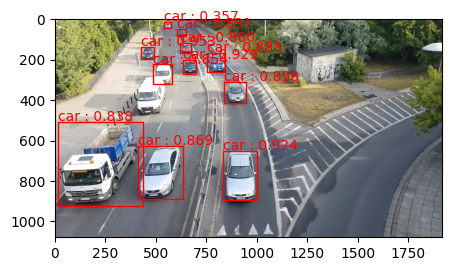

In [85]:
show_prediction(predictions, 0)

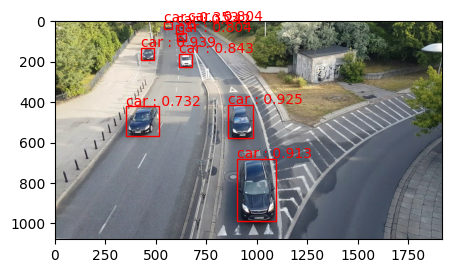

In [86]:
show_prediction(predictions, 1)

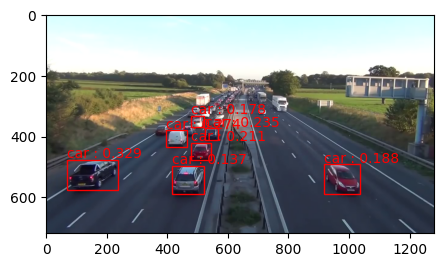

In [87]:
show_prediction(predictions, 2)

# 9) Conclusion

It's pretty obvious to see that the model does not do well at all! It's terrible at predicting cars in night time images and it appears to struggle with small sized cars.

Finetuning the optimzer parameters and training for more epochs ought to improve the model.

Hopefully this is a taster of transfer learning with a real life dataset and real life application!

In [ ]:
# saving and loading the model
torch.save(model, 'model.pth')
model2 = torch.load('model.pth')